# Gaussian Process Regression
## Marginal Likelihood

In [1421]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as spdist
from numpy.linalg import inv, det

from numpy.random import seed, rand, randn

In [1422]:
np.set_printoptions(suppress=True, precision=5, linewidth=100)

In [1423]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [1427]:
x = np.array([-1.3089, 6.7612, 1.0553, -1.1734, -2.9339, 7.2530, -6.5843])[:, None]
y = np.array([1.6218, 1.8558, 0.4102, 1.2526, -0.0133, 1.6380, 0.2189])[:, None]

In [1428]:
def k(u, v, sigma, l):
    return sigma ** 2 * np.exp(-(u - v) ** 2 / (2 * l ** 2))

def gp_predictive_post(xstar, x, y, k, sigma_y, *args):
    kstar = k(x, xstar.T, sigma_f, l)
    Kxx = k(x, x.T, *args) + sigma_y ** 2 * np.eye(n)
    kxx_star = k(xstar, xstar.T, sigma_f, l)
    Kxx_inv = inv(Kxx)
    ystar = kstar.T @ Kxx_inv @ y
    Sigma_post = kxx_star - kstar.T @ Kxx_inv @ kstar
    
    return ystar, Sigma_post

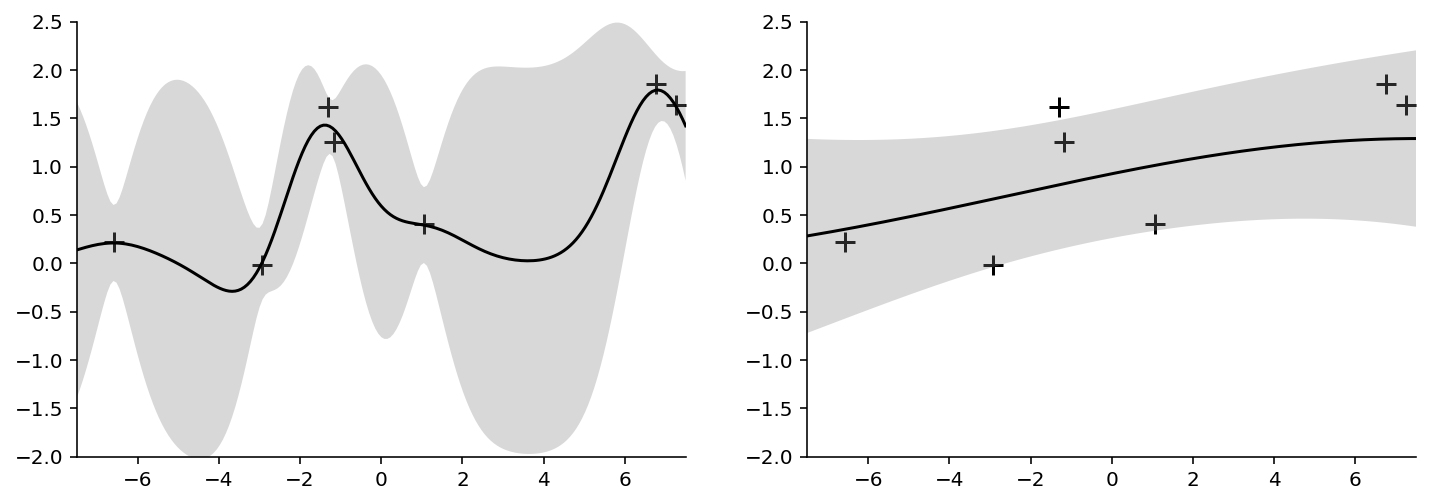

In [1429]:
sigma_f = 1.0
l, sigma_y = 1.0, 0.2
# l, sigma_y = 10, 0.8

configs = [(1.0, 0.2), (10, 0.8)]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for ax, (l, sigma_y) in zip(axs, configs):
    ystar, Sigma_post = gp_predictive_post(xstar, x, y, k, sigma_y, sigma_f, l)
    upper_bound = ystar.ravel() + 2 * np.sqrt(np.diag(Sigma_post))
    lower_bound = ystar.ravel() - 2 * np.sqrt(np.diag(Sigma_post))
    
    ax.scatter(x, y, marker="+", s=100, c="black")
    ax.plot(xstar, ystar, c="black")
    ax.fill_between(xstar.ravel(), lower_bound, upper_bound, color="tab:gray", alpha=0.3, edgecolor="none")
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-2, 2.5)

In [1430]:
def k_logv(u, v, sigma_f, l):
    return sigma_f ** 2 * np.exp(-(u - v) ** 2 / 2)

def log_likelihood(x, y, sigma_f, l, sigma_y):
    n, m = x.shape
    x = x / np.exp(l)
    Kxx = k_logv(x, x.T, sigma_f, l) + np.exp(2 * sigma_y) * np.eye(n)
    s, DKxx = np.linalg.slogdet(Kxx)
    l = -1/2 * (y.T @ inv(Kxx) @ y + DKxx + n * np.log(2 * np.pi))
    return l

In [1471]:
P = np.mgrid[0.1:80:1, 0.03:3:0.05]

ngrid = 41
l_space = np.linspace(np.log(0.5), np.log(80), ngrid)
sigma_y_space = np.linspace(np.log(0.03), np.log(3), ngrid)
P = np.stack(np.meshgrid(l_space, sigma_y_space), axis=0)

In [1486]:
levels = -np.array([8.3, 8.5, 8.9, 9.3, 9.8, 11.5, 15])[::-1]

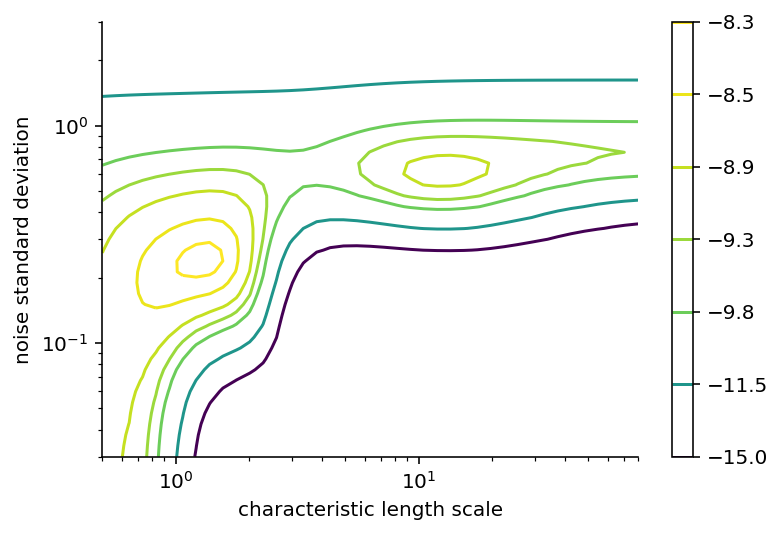

In [1492]:
sigma_f = 1.0
Z = np.apply_along_axis(lambda p: log_likelihood(x, y, sigma_f, *p), 0, P)

plt.contour(*np.exp(P), Z[0, 0], levels=levels)
plt.xlabel("characteristic length scale")
plt.ylabel("noise standard deviation")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()